# Importing the required modules

In [1]:
# Modules used for data handling and manipulation
import numpy as np
import pandas as pd
import json

# Modules used for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

# Modules used for preprocessing
from sklearn.preprocessing import StandardScaler

# Modules for lstm
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization
from keras.callbacks import EarlyStopping

# Module for facebook prophet
import prophet

# Modules used for time series forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Modules used for model evaluation
from sklearn.metrics import mean_absolute_percentage_error
import model

# Modules used for preprocessing
from datetime import datetime, timedelta
import preprocess
from model import Model

# Modules used for object oriented programming
from abc import ABC, abstractmethod

# Module for suppressing warnings
import warnings 
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


# Consolidating the data

In [2]:
electricity = preprocess.preprocess_modelling(as_numpy=False, clustered=True, stationary=False)
temperature = preprocess.preprocess("temperature")
precipitation = preprocess.preprocess("precipitation")

In [3]:
electricity = electricity.drop(pd.to_datetime("2015-01-01"))

In [4]:
electricity0 = electricity[["cluster_0"]]
electricity23 = electricity[["cluster_2", "cluster_3", "cluster_1", "cluster_4"]]

In [5]:
electricity23 = electricity23[366:]

In [6]:
weather = pd.merge(temperature, precipitation, on='date', how='inner').set_index("date")

# SARIMAX

In [15]:
# class for SARIMAX model
class SARIMAX_model(Model):
    
    def __init__(self, data, exogs, cluster: str, start_index = 0, window_stride = 28):
        """
         The constructor for the abstract class Model for standardize evaluation

         Args:
            data: the actual time series that needs to be predicted.
            exogs: the exogeneous variables particularly for SARIMAX.
            cluster: the cluster data which needs to be used (cluster_1 or cluster_0).
            window_stride: the stride (in days) for moving the train-test window; defaults to 28 days.

         Returns:
            - An object of abstract class SARIMA.
        """
        super().__init__(data, cluster, start_index, window_stride)
        self.exogs = exogs
    
    # trains the model
    def train_model(self, train, train_idx):
        model = SARIMAX(endog = train[self.cluster], 
                        exog = self.exogs[train_idx[0]: train_idx[1]], 
                        order = (1, 1, 0), 
                        seasonal_order = (1, 1, 0, 12))
        return model.fit()
    
    # obtains the forecasts for next five time steps
    def get_forecasts(self, test, test_idx):
        return self.trained_model.predict(start = self.data.index[test_idx[0]], 
                                        end = self.data.index[test_idx[0]] + timedelta(len(test) - 1),
                                        exog = self.exogs[test_idx[0]: test_idx[1]])

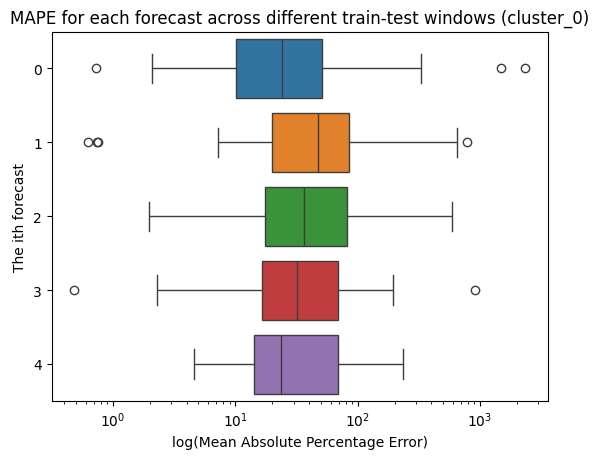

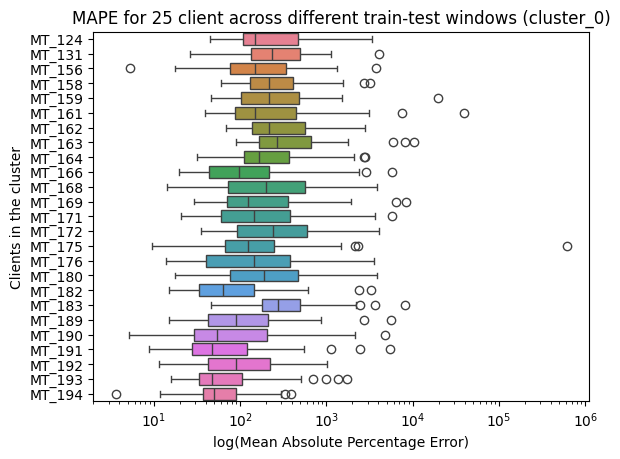

In [16]:
m = SARIMAX_model(electricity0, weather, "cluster_0")
m.cross_validate()
m.mape_boxplot_by_step()
m.mape_boxplot_by_client(25)

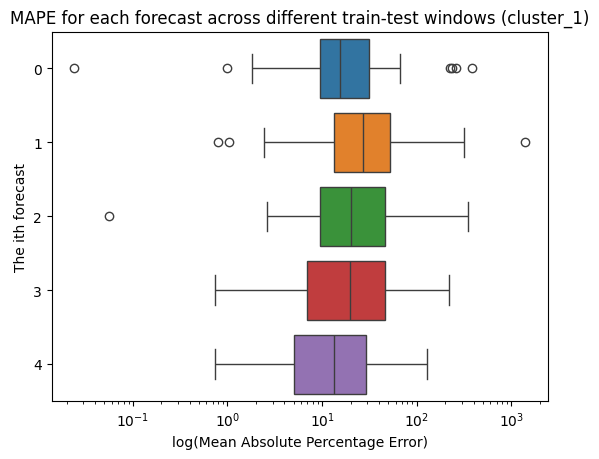

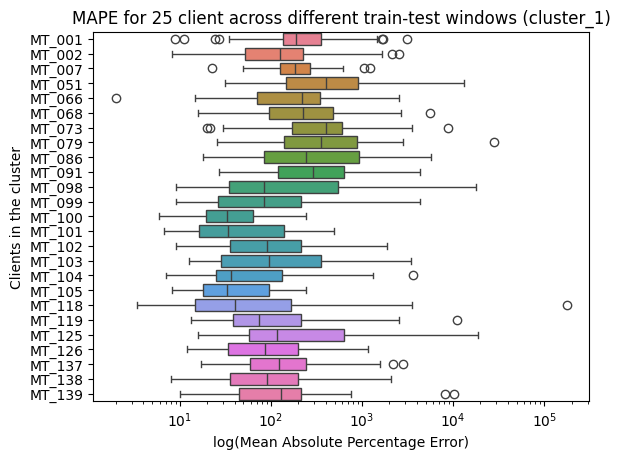

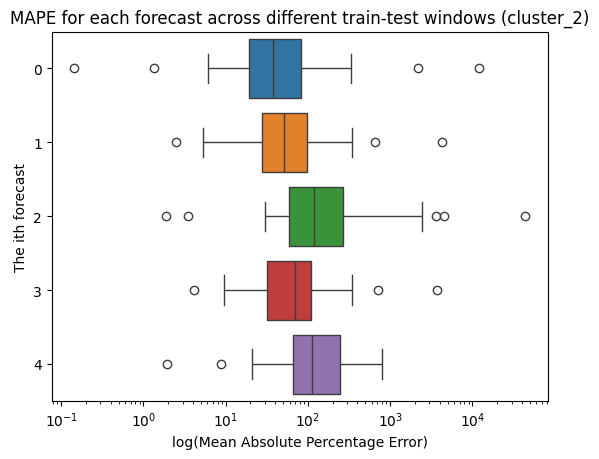

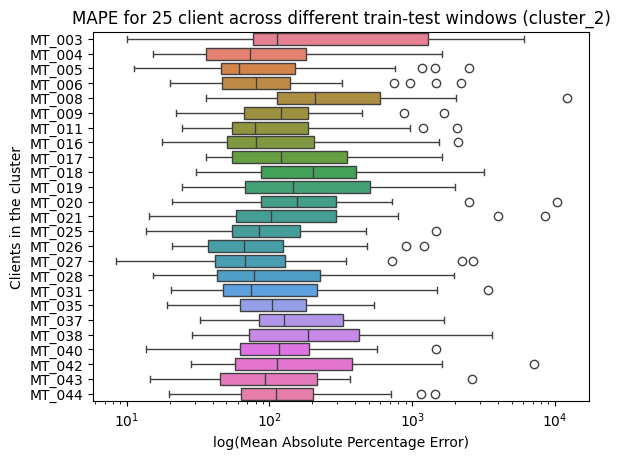

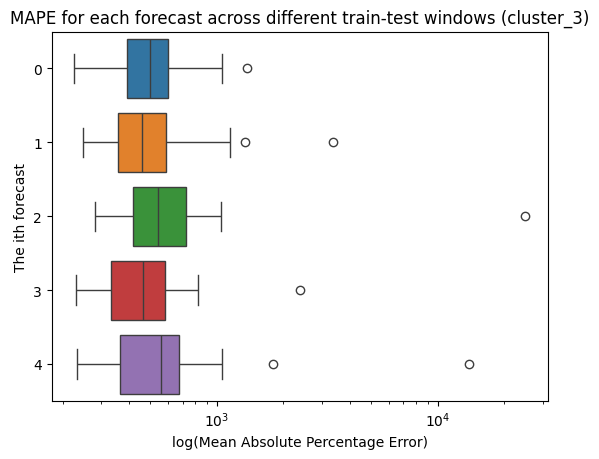

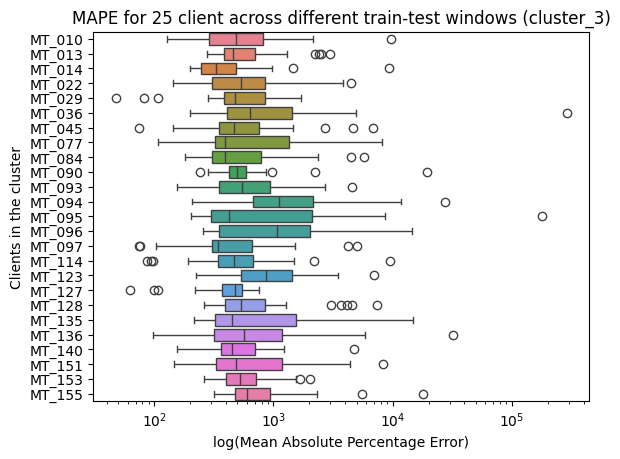

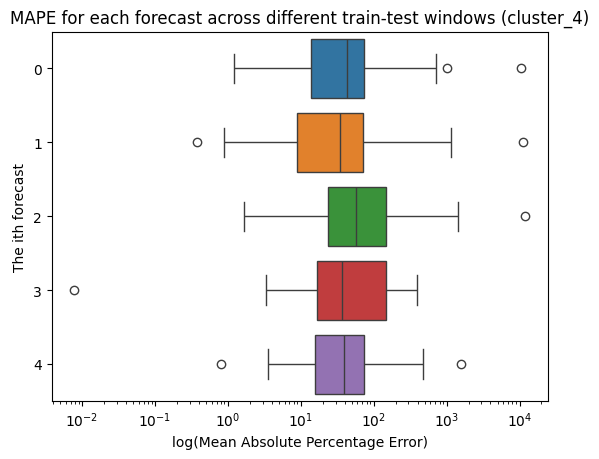

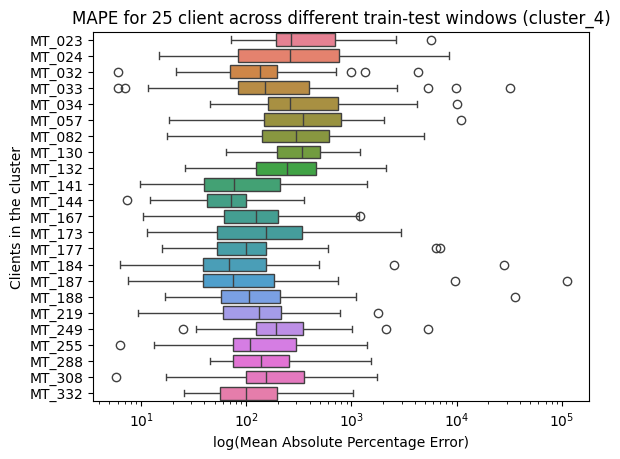

In [17]:
c = ["cluster_1", "cluster_2", "cluster_3", "cluster_4"]
for i in c:
    m = SARIMAX_model(electricity23, weather[366:], i, start_index = 366)
    m.cross_validate()
    m.mape_boxplot_by_step()
    m.mape_boxplot_by_client(25)

# Facebook Prophet

In [ ]:
class FacebookProphet_model(Model):
    
    def __init__(self, exogs, data, cluster, start_index = 0, window_stride = 28):
        super().__init__(data, cluster, start_index, window_stride)
        self.exogs = exogs

    def restructure(self, df):
        df = df.reset_index()
        df["date"] = pd.to_datetime(df["date"])
        df = df.merge(self.exogs.reset_index())
        df = df.rename({"date": "ds", self.cluster:"y"}, axis=1)
        return df

    def train_model(self, train, train_idx):
        model = prophet.Prophet()
        for col in self.exogs.columns:
                model.add_regressor(col)

        #print(train.columns, self.exogs.columns)
        train = self.restructure(train)
        return model.fit(train.reset_index())
    
    def get_forecasts(self, test, test_idx):

        df = self.trained_model.make_future_dataframe(periods = self.ts_test)

        df = self.restructure(df.rename({"ds": "date"}, axis = 1)).drop(["index"], axis = 1)

        return self.trained_model.predict(df)["yhat"][self.ts_train:self.ts_train + self.ts_test]

In [20]:
electricity0

,cluster_0
date,
2011-01-01,6.810210e+06
2011-01-02,1.107161e+07
2011-01-03,1.118024e+07
2011-01-04,1.139913e+07
2011-01-05,1.145297e+07
...,...
2014-12-27,9.185029e+06
2014-12-28,8.974190e+06
2014-12-29,9.055549e+06


In [19]:
m = FacebookProphet_model(weather[366:], electricity0, "cluster_0")
m.cross_validate()
m.mape_boxplot_by_step()
m.mape_boxplot_by_client(25)

ValueError: Dataframe has less than 2 non-NaN rows.

18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] done processing
18:02:08 - cmdstanpy - INFO - Chain [1] start processing
18:02:08 - cmdstanpy - INFO - Chain [1] done processing
18:02:08 - cmdstanpy - INFO - Chain [1] start processing
18:02:08 - cmdstanpy - INFO - Chain [1] done processing
18:02:08 - cmdstanpy - INFO - Chain [1] start processing
18:02:08 - cmdstanpy - INFO - Chain [1] done processing
18:02:08 - cmdstanpy - INFO - Chain [1] start processing
18:02:08 - cmdstanpy - INFO - Chain [1] done processing
18:02:08 - cmdstanpy - INFO - Chain [1] start processing
18:02:08 - cmdstanpy - INFO - Chain [1] done processing
18:02:08 - cmdstanpy - INFO - Chain [1] start processing
18:02:08 - cmdstanpy - INFO - Chain [1] done processing
18:02:08 - cmdstanpy - INFO - Chain [1] start processing
18:02:08 - cmdstanpy - INFO - Chain [1] done processing
18:02:08 - cmdstanpy - INFO - Chain [1] start processing
18:02:08 - cmdstanpy - INFO - Chain [1]

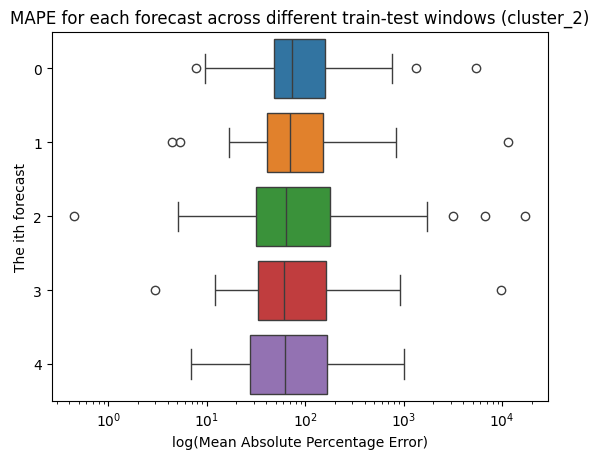

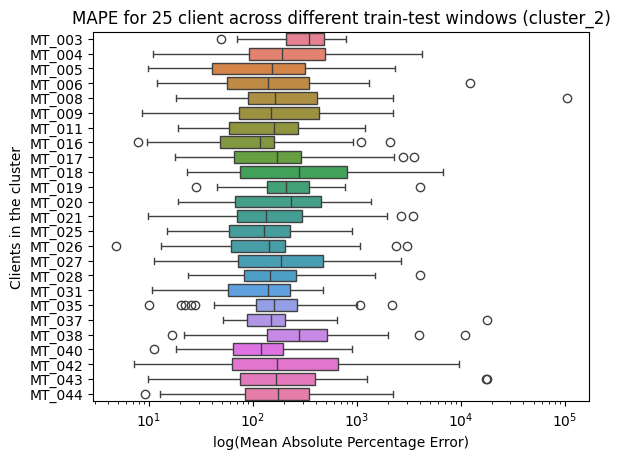

18:02:27 - cmdstanpy - INFO - Chain [1] start processing
18:02:27 - cmdstanpy - INFO - Chain [1] done processing
18:02:27 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing
18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing
18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing
18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing
18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing
18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing
18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing
18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1]

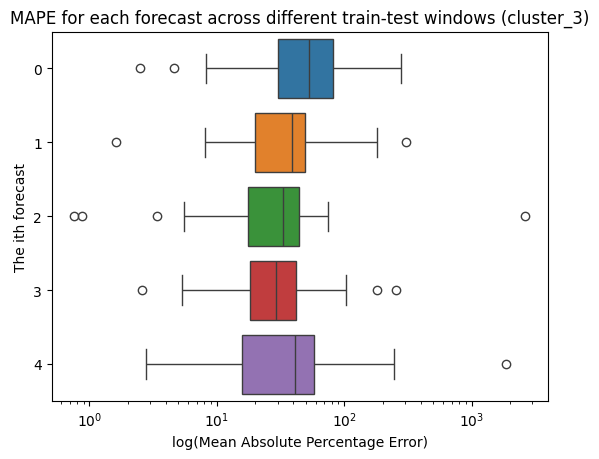

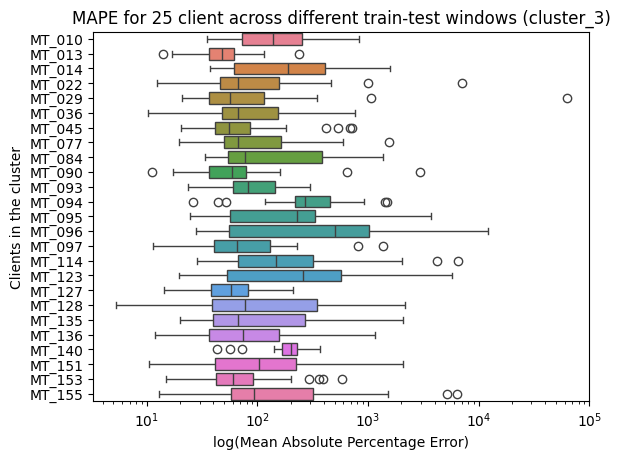

18:02:45 - cmdstanpy - INFO - Chain [1] start processing
18:02:45 - cmdstanpy - INFO - Chain [1] done processing
18:02:45 - cmdstanpy - INFO - Chain [1] start processing
18:02:45 - cmdstanpy - INFO - Chain [1] done processing
18:02:45 - cmdstanpy - INFO - Chain [1] start processing
18:02:45 - cmdstanpy - INFO - Chain [1] done processing
18:02:45 - cmdstanpy - INFO - Chain [1] start processing
18:02:45 - cmdstanpy - INFO - Chain [1] done processing
18:02:45 - cmdstanpy - INFO - Chain [1] start processing
18:02:45 - cmdstanpy - INFO - Chain [1] done processing
18:02:45 - cmdstanpy - INFO - Chain [1] start processing
18:02:45 - cmdstanpy - INFO - Chain [1] done processing
18:02:45 - cmdstanpy - INFO - Chain [1] start processing
18:02:45 - cmdstanpy - INFO - Chain [1] done processing
18:02:45 - cmdstanpy - INFO - Chain [1] start processing
18:02:45 - cmdstanpy - INFO - Chain [1] done processing
18:02:46 - cmdstanpy - INFO - Chain [1] start processing
18:02:46 - cmdstanpy - INFO - Chain [1]

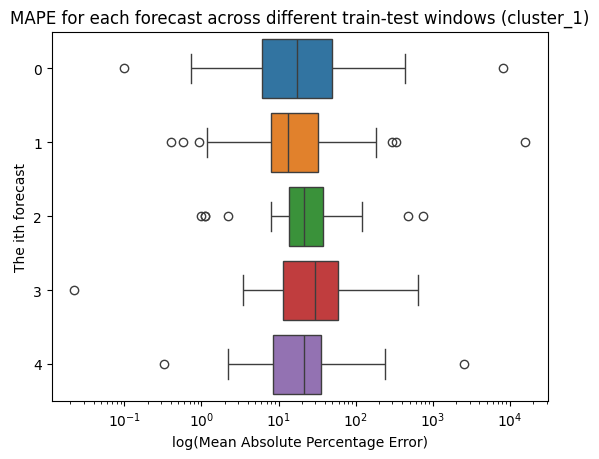

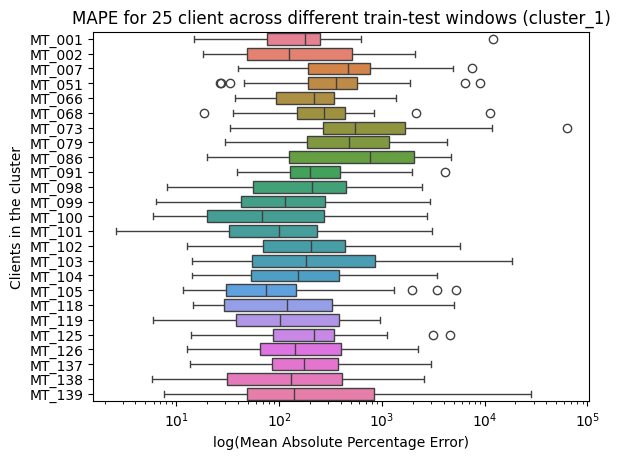

18:03:05 - cmdstanpy - INFO - Chain [1] start processing
18:03:05 - cmdstanpy - INFO - Chain [1] done processing
18:03:05 - cmdstanpy - INFO - Chain [1] start processing
18:03:05 - cmdstanpy - INFO - Chain [1] done processing
18:03:05 - cmdstanpy - INFO - Chain [1] start processing
18:03:05 - cmdstanpy - INFO - Chain [1] done processing
18:03:05 - cmdstanpy - INFO - Chain [1] start processing
18:03:05 - cmdstanpy - INFO - Chain [1] done processing
18:03:06 - cmdstanpy - INFO - Chain [1] start processing
18:03:06 - cmdstanpy - INFO - Chain [1] done processing
18:03:06 - cmdstanpy - INFO - Chain [1] start processing
18:03:06 - cmdstanpy - INFO - Chain [1] done processing
18:03:06 - cmdstanpy - INFO - Chain [1] start processing
18:03:06 - cmdstanpy - INFO - Chain [1] done processing
18:03:06 - cmdstanpy - INFO - Chain [1] start processing
18:03:06 - cmdstanpy - INFO - Chain [1] done processing
18:03:06 - cmdstanpy - INFO - Chain [1] start processing
18:03:06 - cmdstanpy - INFO - Chain [1]

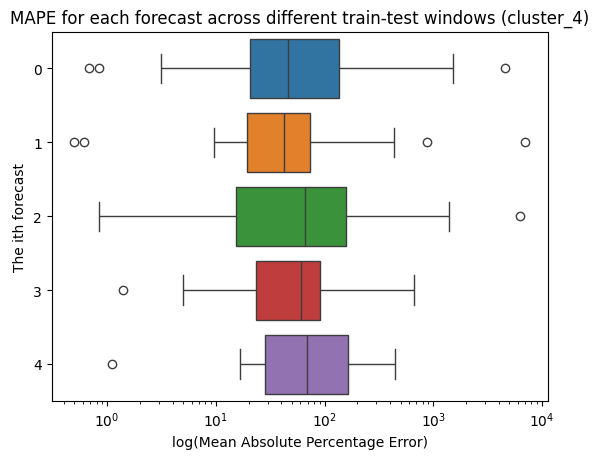

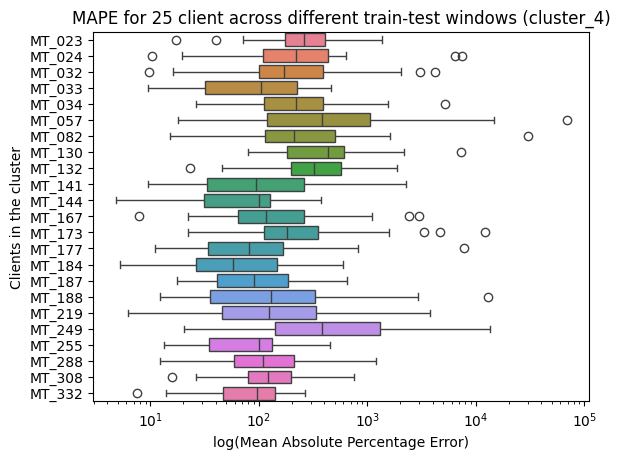

In [ ]:
c = ["cluster_1", "cluster_2", "cluster_3", "cluster_4"] 
for i in c:
    m = FacebookProphet_model(weather[366:], electricity23, i, start_index = 366)
    m.cross_validate()
    m.mape_boxplot_by_step()
    m.mape_boxplot_by_client(25)

16:44:54 - cmdstanpy - INFO - Chain [1] start processing
16:44:54 - cmdstanpy - INFO - Chain [1] done processing
16:44:54 - cmdstanpy - INFO - Chain [1] start processing
16:44:54 - cmdstanpy - INFO - Chain [1] done processing
16:44:54 - cmdstanpy - INFO - Chain [1] start processing
16:44:54 - cmdstanpy - INFO - Chain [1] done processing
16:44:54 - cmdstanpy - INFO - Chain [1] start processing
16:44:54 - cmdstanpy - INFO - Chain [1] done processing
16:44:54 - cmdstanpy - INFO - Chain [1] start processing
16:44:54 - cmdstanpy - INFO - Chain [1] done processing
16:44:54 - cmdstanpy - INFO - Chain [1] start processing
16:44:54 - cmdstanpy - INFO - Chain [1] done processing
16:44:54 - cmdstanpy - INFO - Chain [1] start processing
16:44:54 - cmdstanpy - INFO - Chain [1] done processing
16:44:55 - cmdstanpy - INFO - Chain [1] start processing
16:44:55 - cmdstanpy - INFO - Chain [1] done processing
16:44:55 - cmdstanpy - INFO - Chain [1] start processing
16:44:55 - cmdstanpy - INFO - Chain [1]

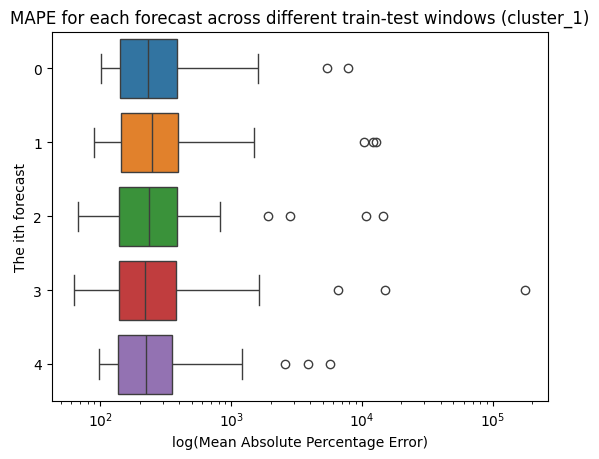

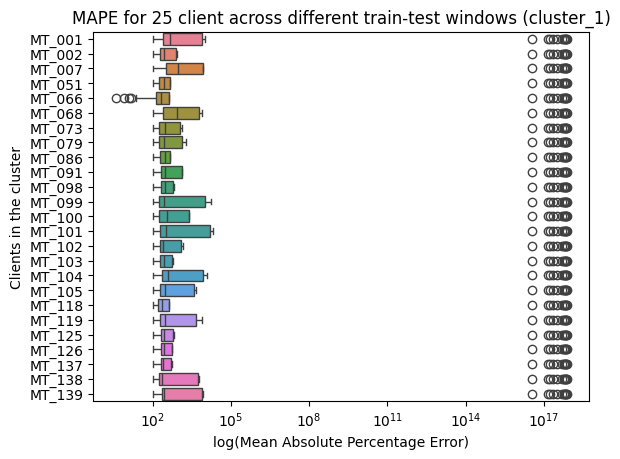

16:45:19 - cmdstanpy - INFO - Chain [1] start processing
16:45:19 - cmdstanpy - INFO - Chain [1] done processing
16:45:19 - cmdstanpy - INFO - Chain [1] start processing
16:45:19 - cmdstanpy - INFO - Chain [1] done processing
16:45:19 - cmdstanpy - INFO - Chain [1] start processing
16:45:20 - cmdstanpy - INFO - Chain [1] done processing
16:45:20 - cmdstanpy - INFO - Chain [1] start processing
16:45:20 - cmdstanpy - INFO - Chain [1] done processing
16:45:20 - cmdstanpy - INFO - Chain [1] start processing
16:45:20 - cmdstanpy - INFO - Chain [1] done processing
16:45:20 - cmdstanpy - INFO - Chain [1] start processing
16:45:20 - cmdstanpy - INFO - Chain [1] done processing
16:45:20 - cmdstanpy - INFO - Chain [1] start processing
16:45:20 - cmdstanpy - INFO - Chain [1] done processing
16:45:20 - cmdstanpy - INFO - Chain [1] start processing
16:45:20 - cmdstanpy - INFO - Chain [1] done processing
16:45:20 - cmdstanpy - INFO - Chain [1] start processing
16:45:20 - cmdstanpy - INFO - Chain [1]

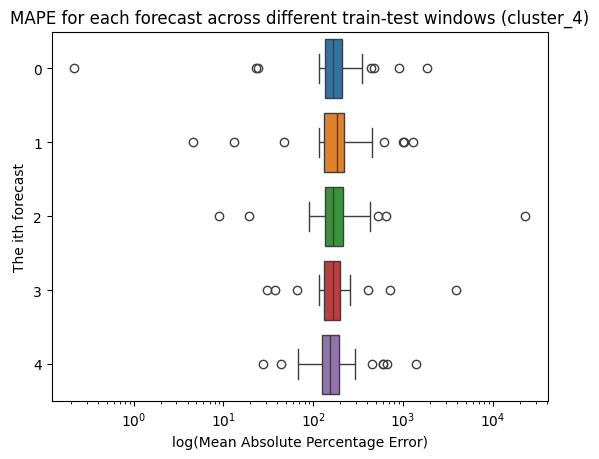

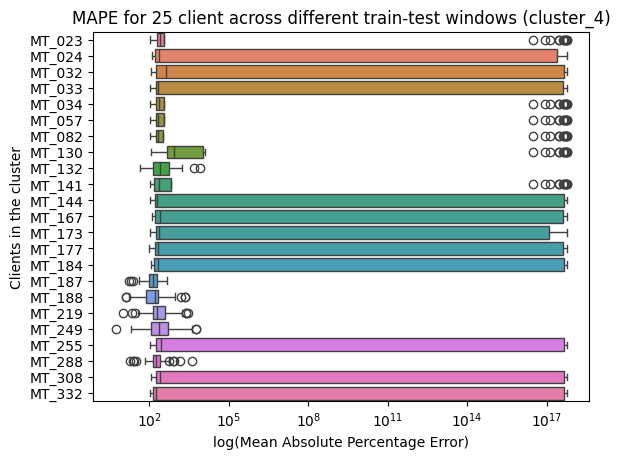

16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] done processing
16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] done processing
16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] done processing
16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] done processing
16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] done processing
16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] done processing
16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] done processing
16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] done processing
16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1]

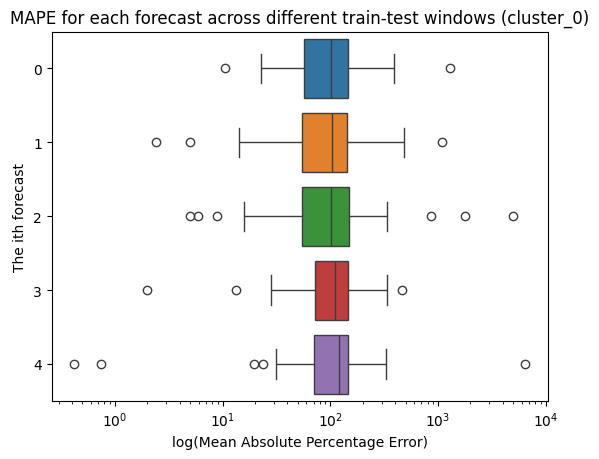

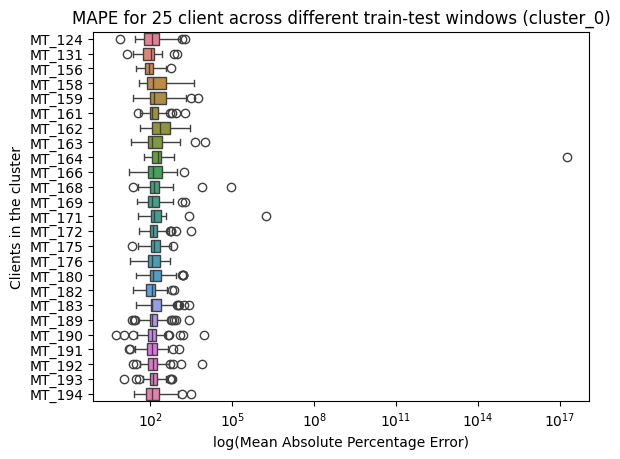

In [ ]:
c = ["cluster_0"] 
x = []
for i in c:
    m = FacebookProphet_model(weather, electricity, i)
    m.cross_validate()
    m.mape_boxplot_by_step()
    m.mape_boxplot_by_client(25)
    x.append(m.d)

In [26]:
x[1]

,MT_023,MT_024,MT_032,MT_033,MT_034,MT_057,MT_082,MT_130,MT_132,MT_141,...,MT_177,MT_184,MT_187,MT_188,MT_219,MT_249,MT_255,MT_288,MT_308,MT_332
0,3.039566e+17,3.039566e+17,3.039566e+17,3.039566e+17,3.039566e+17,3.039566e+17,3.039566e+17,3.039566e+17,203.602513,3.039566e+17,...,3.039566e+17,3.039566e+17,20.531060,578.455784,434.700415,37.120131,3.039566e+17,4125.695483,3.039566e+17,3.039566e+17
1,8.380557e+16,8.380557e+16,8.380557e+16,8.380557e+16,8.380557e+16,8.380557e+16,8.380557e+16,8.380557e+16,129.861133,8.380557e+16,...,8.380557e+16,8.380557e+16,57.087913,203.773265,106.830955,112.864473,8.380557e+16,158.712748,8.380557e+16,8.380557e+16
2,3.081175e+16,3.081175e+16,3.081175e+16,3.081175e+16,3.081175e+16,3.081175e+16,3.081175e+16,3.081175e+16,102.981297,3.081175e+16,...,3.081175e+16,3.081175e+16,106.371899,96.079961,97.511557,86.944630,3.081175e+16,93.550826,3.081175e+16,3.081175e+16
3,1.341885e+17,1.341885e+17,1.341885e+17,1.341885e+17,1.341885e+17,1.341885e+17,1.341885e+17,1.341885e+17,88.723543,1.341885e+17,...,1.341885e+17,1.341885e+17,85.677793,145.288604,131.695462,115.539183,1.341885e+17,117.328267,1.341885e+17,1.341885e+17
4,2.958049e+17,2.958049e+17,2.958049e+17,2.958049e+17,2.958049e+17,2.958049e+17,2.958049e+17,2.958049e+17,45.613647,2.958049e+17,...,2.958049e+17,2.958049e+17,45.955258,139.507907,120.423140,214.030142,2.958049e+17,139.734802,2.958049e+17,2.958049e+17
5,3.993245e+17,3.993245e+17,3.993245e+17,3.993245e+17,3.993245e+17,3.993245e+17,3.993245e+17,3.993245e+17,450.743393,3.993245e+17,...,3.993245e+17,3.993245e+17,17.444454,161.892675,136.047823,252.195806,3.993245e+17,187.886338,3.993245e+17,3.993245e+17
6,4.461472e+17,4.461472e+17,4.461472e+17,4.461472e+17,4.461472e+17,4.461472e+17,4.461472e+17,4.461472e+17,103.079470,4.461472e+17,...,4.461472e+17,4.461472e+17,24.953515,210.772221,237.914755,213.876651,4.461472e+17,192.584668,4.461472e+17,4.461472e+17
7,4.801780e+17,4.801780e+17,4.801780e+17,4.801780e+17,4.801780e+17,4.801780e+17,4.801780e+17,4.801780e+17,154.433854,4.801780e+17,...,4.801780e+17,4.801780e+17,41.175564,181.469377,161.066801,326.648698,4.801780e+17,205.836908,4.801780e+17,4.801780e+17
8,5.597223e+17,5.597223e+17,5.597223e+17,5.597223e+17,5.597223e+17,5.597223e+17,5.597223e+17,5.597223e+17,128.210223,5.597223e+17,...,5.597223e+17,5.597223e+17,65.740187,206.758885,584.720938,210.511499,5.597223e+17,291.819395,5.597223e+17,5.597223e+17
9,5.823568e+17,5.823568e+17,5.823568e+17,5.823568e+17,5.823568e+17,5.823568e+17,5.823568e+17,5.823568e+17,105.824402,5.823568e+17,...,5.823568e+17,5.823568e+17,86.577070,858.878672,1671.067169,92.551222,5.823568e+17,544.474151,5.823568e+17,5.823568e+17


In [ ]:
m = FacebookProphet_model(weather, electricity, "cluster_0")

In [ ]:
m.cross_validate()

In [ ]:
m.mape_boxplot_by_client(25)

In [ ]:
m.mape_boxplot_by_step()

In [ ]:
t = dict()
for i in m.forecasts:
    t[i] = m.forecasts[i]["mape_by_forecast"]

df = pd.DataFrame.from_dict(t, orient = "index")
df.describe()

In [ ]:
m = FacebookProphet_model(weather, electricity, "cluster_1")

In [ ]:
m.cross_validate()

In [ ]:
m.mape_boxplot_by_client(25)

In [ ]:
m.mape_boxplot_by_step()

In [ ]:
class LSTM_model(Model):
    
    def __init__(self, exogs, data, cluster, params: dict, window_stride=28):
        self.exogs = exogs
        data["date"] = pd.to_datetime(data["date"])
        data = data.merge(weather.reset_index())
        self.params = params
        super().__init__(data, cluster, window_stride)

    def restructure(self, X):
        
        x = np.reshape(X[["tmin", "tmax", "precip"]].values, (len(X), 1, 3))
        y = X[self.cluster].values
        
        print(x.shape, y.shape)
        return x, y

    def train_model(self, x_train, y_train):        
        regressor = Sequential()
        regressor.add(Bidirectional(LSTM(units=self.params["num_units"], 
                                         activation=self.params["activation_function"], 
                                         return_sequences=True), 
                                         input_shape=(1,3)))
        regressor.add(Dropout(0.2))
        regressor.add(LSTM(units=self.params["num_units"], activation=self.params["activation_function"], return_sequences=True))
        regressor.add(Dropout(0.2))
        regressor.add(LSTM(units=self.params["num_units"], activation=self.params["activation_function"]))
        regressor.add(Dropout(0.3))
        regressor.add(BatchNormalization())
        regressor.add(Dense(units=64, activation='relu'))
        regressor.add(Dropout(0.2))
        regressor.add(Dense(units=1))

        regressor.compile(optimizer = self.params["optimizer"], loss = self.params["loss_function"])
        regressor.fit(x_train[:self.ts_train - 10], y_train[:self.ts_train - 10], batch_size = self.params["batch_size"], 
                      epochs = self.params["num_epochs"],
                      validation_data = (x_train[self.ts_train - 10:], y_train[self.ts_train - 10:]))

        return regressor
    
    def get_forecasts(self, x_test):

        return self.trained_model.predict(x_test).flatten()
    
    def cross_validate(self):
      
      train_idx = [0, self.ts_train]
      test_idx = [self.ts_train, self.ts_train + self.ts_test]

      for split_id in range(50):
         
         cols = [self.cluster, "tmin", "tmax", "precip"]
         train = self.data[train_idx[0]: train_idx[1]][cols]
         test = self.data[test_idx[0]: test_idx[1]][cols]

         train, test = self.standardize(train, test)

         x_train, y_train = self.restructure(train)
         x_test, y_test = self.restructure(test)

         self.trained_model = self.train_model(x_train, y_train)

         preds = self.get_forecasts(x_test)
         
         self.forecasts[split_id] = {"pred": list(preds),
                                     "train_date_range": train_idx,
                                     "test_date_range": test_idx}
   
         test_np = y_test.flatten()
         mape_by_forecast = np.abs((test_np - self.forecasts[split_id]["pred"])/(test_np))*100
         self.forecasts[split_id]["mape_by_forecast"] = mape_by_forecast

         train_idx = [train_idx[0] + self.ts_window_stride, 
                     min(train_idx[1] + self.ts_window_stride, 
                        self.MAX_IDX)]
         test_idx = [test_idx[0] + self.ts_window_stride, 
                     min(test_idx[1] + self.ts_window_stride, 
                        self.MAX_IDX)]
        
         if test_idx[0] > len(self.data):
            break

In [ ]:
params = {
    "num_units": 60,
    "activation_function": 'relu',
    "optimizer": "adam",
    "loss_function": "mean_absolute_percentage_error",
    "batch_size": 32,
    "num_epochs": 20
}

m = LSTM_model(weather.reset_index(), electricity.reset_index()[366:], i, params)
m.cross_validate()
m.mape_boxplot_by_step()
m.mape_boxplot_by_client(25)

# m = LSTM_model(weather.reset_index(), np.log(electricity/4).reset_index(), "cluster_0", params, window_stride = 28)

In [ ]:
m.cross_validate()

In [ ]:
m.mape_boxplot_by_step()

In [ ]:
t = dict()
for i in m.forecasts:
    t[i] = m.forecasts[i]["mape_by_forecast"]

df = pd.DataFrame.from_dict(t, orient = "index")
df.describe()

In [ ]:
m.mape_boxplot_by_client(25)

In [ ]:
params = {
    "num_units": 60,
    "activation_function": 'tanh',
    "optimizer": "adam",
    "loss_function": "mean_absolute_percentage_error",
    "batch_size": 32,
    "num_epochs": 100
}

m = LSTM_model(weather.reset_index(), (electricity/4).reset_index(), "cluster_1", params, window_stride = 28)

In [ ]:
m.cross_validate()

In [ ]:
m.mape_boxplot_by_step()

In [ ]:
m.mape_boxplot_by_client(25)